<a href="https://colab.research.google.com/github/Montse1708/ProyectoFinal_Dashboard/blob/main/TI_1_ProyectoFinal_JessicaMorales_CarlaSanchez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Proyecto Final**

##Integrantes:
* **Nombre:** Jessica Montserrat Morales Enrique  
* **e-mail:** jessica.morales5556@alumnos.udg.mx

- **Nombre:** Carla Georgina Sánchez Arreguín
- **email:** carla.sanchez2472@alumnos.udg.mx

#MODULES

##Install modules

In [4]:
pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.3 MB/s eta 0:00:00


In [5]:
pip install panel

In [6]:
import numpy as np
import pandas as pd
import math
import geopandas as gpd
import folium
import panel as pn
import panel.widgets as pnw
from unidecode import unidecode
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import plotly.graph_objects as go

import plotly.express as px

#DATASET

##Dataset de COVID en México

###Dataset almacenado en link

In [7]:
#Cargar los datos del archivo CSV
#En el siguiente link se encuentra los datos almacenados
url = 'https://raw.githubusercontent.com/marianarf/covid19_mexico_analysis/master/mexico_covid19.csv'
df = pd.read_csv(url)

###Dataset descargado de Kaggle


In [ ]:
#Cargar el dataset con los datos
#Link del repositorio en Kaggle: https://www.kaggle.com/datasets/marianarfranklin/mexico-covid19-clinical-data?resource=download
df = pd.read_csv('/content/mexico_covid19.csv')

##GeoJSON de los límites de los estados de México

In [8]:
# Descargar el archivo GeoJSON de los límites de México
geojson_url = 'https://raw.githubusercontent.com/angelnmara/geojson/master/mexicoHigh.json'
mexico_map = gpd.read_file(geojson_url)

#MOSTRAR MAPA

In [9]:
# Verificar y corregir geometrías inválidas
mexico_map['geometry'] = mexico_map['geometry'].apply(lambda x: x.buffer(0) if x.is_valid else x)

# Quitar acentos de los nombres de los estados
mexico_map['name'] = mexico_map['name'].apply(unidecode)

# Renombrar la columna 'ENTIDAD' a 'name' en el DataFrame df
df.rename(columns={'ENTIDAD': 'name'}, inplace=True)

# Calcular el total de casos por estado
total_casos_por_estado = df.groupby('name').size().reset_index(name='total_casos')

# Unir los datos de casos con el archivo GeoJSON
mexico_map = mexico_map.merge(total_casos_por_estado, on='name', how='left')

In [20]:
def update_marker(selected_estado):
    # Crear un nuevo mapa para cada actualización
    m = folium.Map(location=[23.634501, -102.525593], zoom_start=5)

    for _, row in mexico_map.iterrows():
        if selected_estado == 'Todos' or selected_estado == row['name']:
            if row['geometry'].geom_type == 'Polygon' or row['geometry'].geom_type == 'MultiPolygon':
                if row['geometry'].geom_type == 'Polygon':
                    polygons = [row['geometry']]
                else:
                    polygons = row['geometry'].geoms

                for polygon in polygons:
                    coords = polygon.exterior.coords
                    # Verificar si la longitud de las coordenadas es mayor que un umbral
                    if len(coords) > 3:  # Considerar solo geometrías que representan estados individuales
                        center_lat = sum(p[1] for p in coords) / len(coords)
                        center_lon = sum(p[0] for p in coords) / len(coords)
                        folium.Marker(
                            location=[row['geometry'].centroid.y, row['geometry'].centroid.x],
                            popup=folium.Popup(f"Estado: {row['name']} Total de casos: {row['total_casos']}"),
                            icon=folium.Icon(color='red', icon='info-sign')
                        ).add_to(m)
    return m

In [29]:
pn.extension()
selectEstado = pnw.Select(name="Estado:", width=220, value='Todos', options=['Todos'] + mexico_map['name'].tolist())

map_callback = pn.bind(update_marker, selectEstado)
map_pane = pn.pane.HTML(map_callback, width=800, height=600)

dashboard = pn.Row(map_pane)
dashboard

Row
    [0] HTML(Map, height=600, sizing_mode='fixed', width=800)

# Matriz de Correlación

In [127]:
def create_correlation_matrix_panel(df, sexo, edad):
    # Filtrar el DataFrame según los parámetros seleccionados

    if sexo != 'Todos' and edad != 0:
        df_filtrado = df[((df['SEXO'] == 1) | (df['SEXO'] == 2) ) & (df['EDAD'] == edad)]
    elif sexo != 'Todos':
        df_filtrado = df[df['SEXO'] == sexo]
    elif edad != 0:
        df_filtrado = df[df['EDAD'] == edad]
    else:
        df_filtrado = df

    columnas_seleccionadas = ["DIABETES", "EPOC", "ASMA", "INMUSUPR", "HIPERTENSION", "OTRA_COM", "CARDIOVASCULAR", "OBESIDAD",
                               "RENAL_CRONICA", "TABAQUISMO"]

    df_filtrado = df_filtrado[columnas_seleccionadas]
    matriz_correlacion = df_filtrado.corr()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))  # Ajusta el tamaño de la figura aquí

    sns.heatmap(
        matriz_correlacion,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        linewidths=.5,
        annot_kws={"size": 8},
        cbar_kws={"shrink": 0.6},
        ax=ax
    )

    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right',
        fontsize=8
    )

    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0,
        horizontalalignment='right',
        fontsize=8
    )

    plt.tight_layout()  # Ajusta el espaciado entre subplots automáticamente

    ax.set_title("Matriz de Correlación", fontsize=8, pad=5)
    plt.close()  # Cerrar el gráfico para evitar que se muestre automáticamente

    # Convertir el gráfico en un objeto Panel
    matrix_panel = pn.pane.Matplotlib(fig)
    return matrix_panel

Matplotlib(Figure)
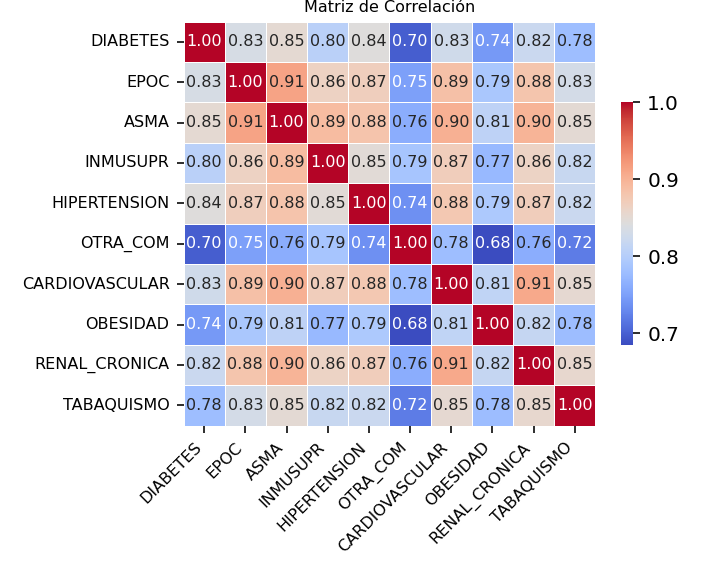

In [133]:
# Crear la matriz de correlación para todos los datos
correlation_matrix_panel = create_correlation_matrix_panel(df, 'Todos', 0)

# Mostrar la matriz de correlación
correlation_matrix_panel

#Mostrar Dashboard

Row(styles={'background': '...})
    [0] Column
        [0] Markdown(str)
        [1] Select(name='Estado:', options=['Todos', 'Zacatecas', ...], value='Todos', width=150)
        [2] Select(name='Sexo', options=['Todos', 'Masculino', ...], value='Todos', width=150)
        [3] IntSlider(end=120, name='Edad', width=150)
        [4] StaticText(value='Métrica:')
        [5] RadioButtonGroup(name='Metrica', options=['Matriz de correlación'], value='Matriz de correlación', width=100)
    [1] HTML(Map, height=600, sizing_mode='fixed', width=800)
    [2] Matplotlib(Figure)
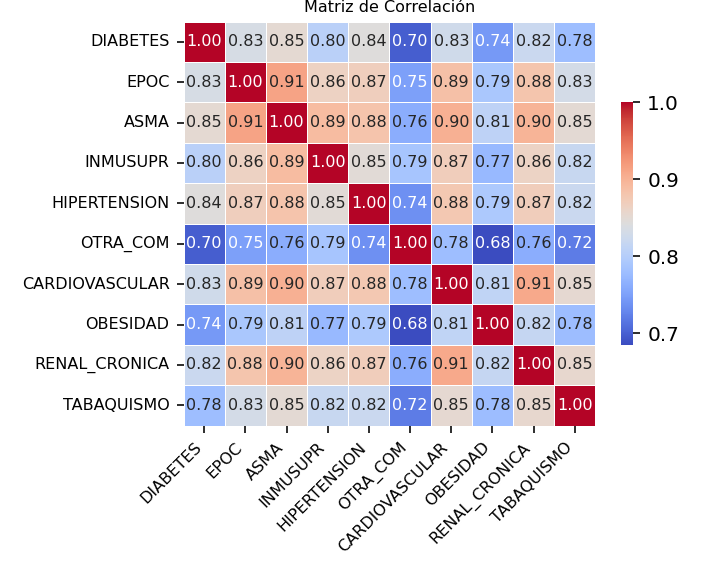

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


In [134]:
# Texto en formato markdown para el panel
markdown_text = """
# DASHBOARD

### Panel params
"""
# Crear un panel con el texto markdown
panel = pn.panel(markdown_text)

#############################
# Definir la función que se llamará al cambiar el valor del input
def update_correlation_matrix(event):
    sexo_value = sexo_selector.value
    edad_value = edad_selector.value
    new_matrix = create_correlation_matrix_panel(df, sexo_value, edad_value)
    correlation_matrix_panel.object = new_matrix.object

# Crear widgets para seleccionar
selectEstado = pnw.Select(name="Estado:", width=150, value='Todos', options=['Todos'] + mexico_map['name'].tolist())
sexo_options = ['Todos', 'Masculino', 'Femenino']
sexo_selector = pnw.Select(options=sexo_options, name='Sexo', width=150)
edad_selector = pnw.IntSlider(start=0, end=120, step=1, value=0, name='Edad', width=150)
metrica = pnw.RadioButtonGroup(name='Metrica', width=100, options=['Matriz de correlación'])
subtitulo = pnw.StaticText(value='Métrica:')

# Crear matriz de correlación inicial
correlation_matrix_panel = create_correlation_matrix_panel(df, 'Todos', 0)

# Conectar widgets con la actualización de la matriz de correlación
sexo_selector.param.watch(update_correlation_matrix, 'value')
edad_selector.param.watch(update_correlation_matrix, 'value')

map_callback = pn.bind(update_marker, selectEstado)
map_panel = pn.pane.HTML(map_callback, width=800, height=600)

# Organizar widgets y matriz de correlación en una columna vertical
pn.Row(pn.Column(markdown_text, selectEstado, sexo_selector, edad_selector, subtitulo, metrica),
            map_panel, correlation_matrix_panel,
    styles={'background': 'lightcyan'}
)